# Differential drive robot (a.k.a., the "segbot")

Import modules and configure the notebook.

In [1]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_segbot

# I often go back and forth between making changes to my scripts and to
# the notebook in which they are used. One "gotcha" is that notebooks only
# import modules or scripts ONCE. Subsequent imports don't do anything, and
# in particular won't reflect any changes I've made to my scripts. To make
# sure that I'm working with the latest version of my code, I use this bit
# of magic, which forces the notebook to "reload" my script:
import importlib
importlib.reload(ae353_segbot)

<module 'ae353_segbot' from 'c:\\Users\\anshu\\Desktop\\Class Materials\\AE 353 Git\\ae353-sp21\\projects\\02_segbot\\ae353_segbot.py'>

Create an instance of the robot simulator. This will open a window in which you should see the segbot.

There are four optional parameters:

* `damping` is the coefficient of viscous friction at each wheel joint (the default value is `0.`)
* `dt` is the length of each time step in the simulator (the default value is `0.01`)
* `two_robots` will change the number of robots in the simulation from 1 to 2
* `display` is a flag that says whether or not to open the GUI (the default value is `True`)

The `display` parameter, in particular, is likely to be of use to you. If you set `display=True`, then you will run the simulator in real-time with a GUI. If you set `display=False`, then you will run the simulator as fast as possible (faster than real-time) without a GUI. This is convenient when all you want is the data.

**NOTE:** it is still necessary to reset the kernel (see the "Kernel" menu above) before creating a new instance of the robot simulator, even when running without a GUI - if you don't, then you'll notice that simulation slows way down.

In [2]:
two_robots = True

In [3]:
robot = ae353_segbot.RobotSimulator(damping=0., dt=0.01, two_robots=two_robots, display=True)

Define and create an instance of the robot controller. By default, it chooses to apply zero torque both to the gimbal and to the rotor. Modify the `run` function - or anything else in the class definition - to make the controller behave differently.

In [4]:
K1 = np.array([[-3.872983346207442,
  -12.385264813293213,
  -0.7071067811866314,
  -4.668390345553667,
  -23.118474300975123,
  -4.691015172265555],
 [3.8729833462073926,
  12.38526481329312,
  -0.7071067811866456,
  4.668390345553622,
  -23.118474300975038,
  -4.691015172265555]])

K2 = np.array([[-3.5355339059326973,
  -11.462230976904468,
  -0.9128709291750994,
  -4.387281935445986,
  -23.13326282519175,
  -4.3568742351744625],
 [3.5355339059327457,
  11.462230976904587,
  -0.9128709291751278,
  4.38728193544597,
  -23.133262825191636,
  -4.35687423517447]])

In [5]:
class RobotController:
    def __init__(self, dt=0.01, K = K1):
        self.dt = dt
        self.v_des = 4
        self.e_l_des = -0.3
        self.K = K

    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        x = np.array([[lateral_error-self.e_l_des], [heading_error], [forward_speed - self.v_des], [turning_rate], [pitch_angle], [pitch_rate]])
        u = -self.K @ x

        tau_left = u[0] # <-- Torque to left wheel
        tau_right = u[1] # <-- Torque to right wheel
        
        return tau_left, tau_right

controller = RobotController(dt=robot.dt)

In [6]:
#Controller for robot 2
class RobotController2:
    def __init__(self, dt=0.01, K = K2):
        self.dt = dt
        self.v_des = 4
        self.e_l_des = -0.3
        self.K = K

    def run(self, lateral_error, heading_error, forward_speed, turning_rate, pitch_angle, pitch_rate):
        x = np.array([[lateral_error-self.e_l_des], [heading_error], [forward_speed - self.v_des], [turning_rate], [pitch_angle], [pitch_rate]])
        u = -self.K @ x

        tau_left = u[0] # <-- Torque to left wheel
        tau_right = u[1] # <-- Torque to right wheel
        
        return tau_left, tau_right

controller2 = RobotController2(dt=robot.dt)

Run the simulation. It is a loop. At each iteration, we:
* get sensor measurements
* choose actuator commands
* go forward one time step

We also log data so that we can plot it later, if we want.

In [7]:
# Restore the simulation to its initial state
robot.reset(turn_left=False,            # does the robot turn left or right around the track
            ground_pitch=0.0,            # angle that the track is sloped (rad)
            initial_speed=0.0,           # initial forward speed of segbot (m/s)
            initial_lateral_error=0.,   # initial lateral error of segbot (m)
            initial_heading_error=0.,   # initial heading error of segbot (rad)
            initial_pitch=0.)           # initial pitch angle of chassis (rad)

# Choose a camera view
# robot.camera_sideview()
# robot.camera_topview()
# robot.camera_chaseview(yaw=270.) # For robot 1


# Choose how long we want to run the simulation, and
# compute the corresponding number of time steps
run_time = 80.
num_steps = int(run_time/robot.dt)

if (two_robots):
    # Create a dictionary in which to store results
    data = {
        't': np.empty(num_steps, dtype=float),
        'lateral_error1': np.empty(num_steps, dtype=float),
        'heading_error1': np.empty(num_steps, dtype=float),
        'forward_speed1': np.empty(num_steps, dtype=float),
        'turning_rate1': np.empty(num_steps, dtype=float),
        'pitch_angle1': np.empty(num_steps, dtype=float),
        'pitch_rate1': np.empty(num_steps, dtype=float),
        'tau_left_command1': np.empty(num_steps, dtype=float),
        'tau_right_command1': np.empty(num_steps, dtype=float),
        'tau_left1': np.empty(num_steps, dtype=float),
        'tau_right1': np.empty(num_steps, dtype=float),
        'lateral_error2': np.empty(num_steps, dtype=float),
        'heading_error2': np.empty(num_steps, dtype=float),
        'forward_speed2': np.empty(num_steps, dtype=float),
        'turning_rate2': np.empty(num_steps, dtype=float),
        'pitch_angle2': np.empty(num_steps, dtype=float),
        'pitch_rate2': np.empty(num_steps, dtype=float),
        'tau_left_command2': np.empty(num_steps, dtype=float),
        'tau_right_command2': np.empty(num_steps, dtype=float),
        'tau_left2': np.empty(num_steps, dtype=float),
        'tau_right2': np.empty(num_steps, dtype=float),
    }
else:
    data = {
        't': np.empty(num_steps, dtype=float),
        'lateral_error1': np.empty(num_steps, dtype=float),
        'heading_error1': np.empty(num_steps, dtype=float),
        'forward_speed1': np.empty(num_steps, dtype=float),
        'turning_rate1': np.empty(num_steps, dtype=float),
        'pitch_angle1': np.empty(num_steps, dtype=float),
        'pitch_rate1': np.empty(num_steps, dtype=float),
        'tau_left_command1': np.empty(num_steps, dtype=float),
        'tau_right_command1': np.empty(num_steps, dtype=float),
        'tau_left1': np.empty(num_steps, dtype=float),
        'tau_right1': np.empty(num_steps, dtype=float)
    }

# Run the simulation loop
start_time = time.time()
for step in range(num_steps):
    # Get the current time
    t = robot.dt * step
    
    # Get the sensor measurements
    (lateral_error1,
     heading_error1,
     forward_speed1,
     turning_rate1,
     pitch_angle1,
     pitch_rate1) = robot.get_sensor_measurements(robot.robot1_id,robot.joint_ids1)

    
    # Choose the actuator command (by running the controller) for robot 1
    tau_left_command1, tau_right_command1 = controller.run(lateral_error1,
                                                         heading_error1,
                                                         forward_speed1,
                                                         turning_rate1,
                                                         pitch_angle1,
                                                         pitch_rate1)
    
    # Apply the actuator commands for robot 1
    tau_left1, tau_right1 = robot.set_actuator_commands(robot.robot1_id, robot.joint_ids1, tau_left_command1, tau_right_command1)
    
    # Log the data for robot 1 from this time step
    data['t'][step] = t
    data['lateral_error1'][step] = lateral_error1
    data['heading_error1'][step] = heading_error1
    data['forward_speed1'][step] = forward_speed1
    data['turning_rate1'][step] = turning_rate1
    data['pitch_angle1'][step] = pitch_angle1
    data['pitch_rate1'][step] = pitch_rate1
    data['tau_left_command1'][step] = tau_left_command1
    data['tau_right_command1'][step] = tau_right_command1
    data['tau_left1'][step] = tau_left1
    data['tau_right1'][step] = tau_right1
    
    if (two_robots):
        # Get the sensor measurements
        (lateral_error2,
        heading_error2,
        forward_speed2,
        turning_rate2,
        pitch_angle2,
        pitch_rate2) = robot.get_sensor_measurements(robot.robot2_id,robot.joint_ids2)

         # Choose the actuator command (by running the controller) for robot 2
        tau_left_command2, tau_right_command2 = controller2.run(lateral_error2,
                                                            heading_error2,
                                                            forward_speed2,
                                                            turning_rate2,
                                                            pitch_angle2,
                                                            pitch_rate2)
        

        # Apply the actuator commands for robot 2
        tau_left2, tau_right2 = robot.set_actuator_commands(robot.robot2_id, robot.joint_ids2, tau_left_command2, tau_right_command2)

        # Log the data for robot 2 from this time step
        data['lateral_error2'][step] = lateral_error2
        data['heading_error2'][step] = heading_error2
        data['forward_speed2'][step] = forward_speed2
        data['turning_rate2'][step] = turning_rate2
        data['pitch_angle2'][step] = pitch_angle2
        data['pitch_rate2'][step] = pitch_rate2
        data['tau_left_command2'][step] = tau_left_command2
        data['tau_right_command2'][step] = tau_right_command2
        data['tau_left2'][step] = tau_left2
        data['tau_right2'][step] = tau_right2
    
    # Simulate one time step
    robot.step(t=(start_time + (robot.dt * (step + 1))))

An example of how to plot results. This is just an example!

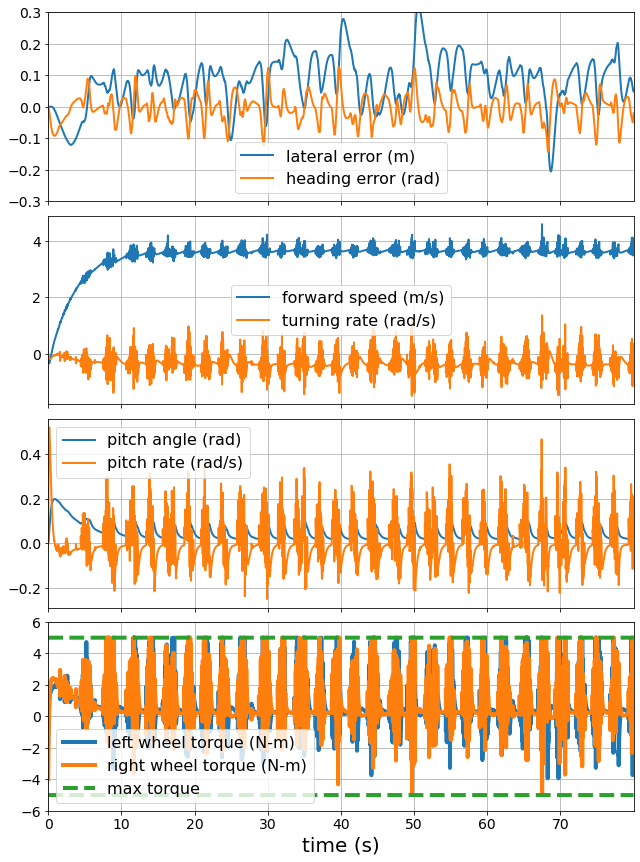

In [8]:
# Create a figure with four subplots, all of which share the same x-axis
fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

# First subplot
ax[0].plot(data['t'], data['lateral_error1'], label='lateral error (m)', linewidth=2)
ax[0].plot(data['t'], data['heading_error1'], label='heading error (rad)', linewidth=2)
ax[0].grid()
ax[0].legend(fontsize=16)
ax[0].tick_params(labelsize=14)
ax[0].set_ylim(-0.3,0.3)


# Second subplot
ax[1].plot(data['t'], data['forward_speed1'], label='forward speed (m/s)', linewidth=2)
ax[1].plot(data['t'], data['turning_rate1'], label='turning rate (rad/s)', linewidth=2)
ax[1].grid()
ax[1].legend(fontsize=16)
ax[1].tick_params(labelsize=14)

# Third subplot
ax[2].plot(data['t'], data['pitch_angle1'], label='pitch angle (rad)', linewidth=2)
ax[2].plot(data['t'], data['pitch_rate1'], label='pitch rate (rad/s)', linewidth=2)
ax[2].grid()
ax[2].legend(fontsize=16)
ax[2].tick_params(labelsize=14)

# Fourth subplot
ax[3].plot(data['t'], data['tau_left1'], label='left wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], data['tau_right1'], label='right wheel torque (N-m)', linewidth=4)
ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
ax[3].grid()
ax[3].legend(fontsize=16)
ax[3].tick_params(labelsize=14)
ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

# Set x-axis properties (only need to do this on the fourth
# subplot since all four subplots share the same x-axis)
ax[3].set_xlabel('time (s)', fontsize=20)
ax[3].set_xlim([data['t'][0], data['t'][-1]])

# Make the arrangement of subplots look nice
fig.tight_layout()

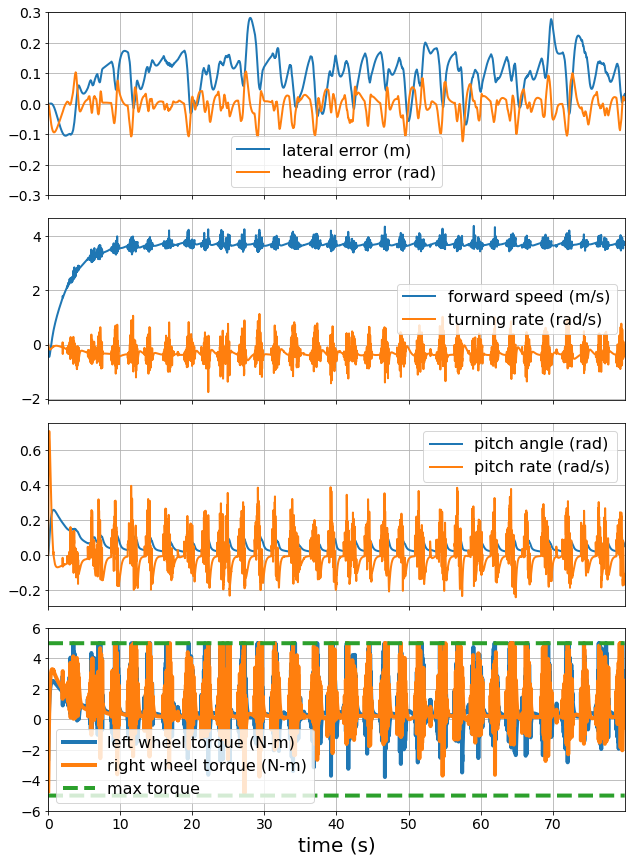

In [9]:
if (two_robots):
    # Create a figure with four subplots, all of which share the same x-axis
    fig, ax = plt.subplots(4, 1, figsize=(9, 12), sharex=True)

    # First subplot
    ax[0].plot(data['t'], data['lateral_error2'], label='lateral error (m)', linewidth=2)
    ax[0].plot(data['t'], data['heading_error2'], label='heading error (rad)', linewidth=2)
    ax[0].grid()
    ax[0].legend(fontsize=16)
    ax[0].tick_params(labelsize=14)
    ax[0].set_ylim(-0.3,0.3)

    # Second subplot
    ax[1].plot(data['t'], data['forward_speed2'], label='forward speed (m/s)', linewidth=2)
    ax[1].plot(data['t'], data['turning_rate2'], label='turning rate (rad/s)', linewidth=2)
    ax[1].grid()
    ax[1].legend(fontsize=16)
    ax[1].tick_params(labelsize=14)

    # Third subplot
    ax[2].plot(data['t'], data['pitch_angle2'], label='pitch angle (rad)', linewidth=2)
    ax[2].plot(data['t'], data['pitch_rate2'], label='pitch rate (rad/s)', linewidth=2)
    ax[2].grid()
    ax[2].legend(fontsize=16)
    ax[2].tick_params(labelsize=14)

    # Fourth subplot
    ax[3].plot(data['t'], data['tau_left2'], label='left wheel torque (N-m)', linewidth=4)
    ax[3].plot(data['t'], data['tau_right2'], label='right wheel torque (N-m)', linewidth=4)
    ax[3].plot(data['t'], np.ones_like(data['t']) * robot.tau_max, '--', label='max torque', linewidth=4, color='C2')
    ax[3].plot(data['t'], -np.ones_like(data['t']) * robot.tau_max, '--', linewidth=4, color='C2')
    ax[3].grid()
    ax[3].legend(fontsize=16)
    ax[3].tick_params(labelsize=14)
    ax[3].set_ylim(-1.2 * robot.tau_max, 1.2 * robot.tau_max)

    # Set x-axis properties (only need to do this on the fourth
    # subplot since all four subplots share the same x-axis)
    ax[3].set_xlabel('time (s)', fontsize=20)
    ax[3].set_xlim([data['t'][0], data['t'][-1]])

    # Make the arrangement of subplots look nice
    fig.tight_layout()
